In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

## Обработка данных

In [2]:
customers_df =  pd.read_csv('customers.csv', encoding="ISO-8859-1")

In [3]:
orders_df =  pd.read_csv('orders.csv', encoding="ISO-8859-1")

In [4]:
customers_df.head()

,id,name,segment,state,city
0,CG-12520,Claire Gute,Consumer,Kentucky,Henderson
1,DV-13045,Darrin Van Huff,Corporate,California,Los Angeles
2,SO-20335,Sean O'Donnell,Consumer,Florida,Fort Lauderdale
3,BH-11710,Brosina Hoffman,Consumer,California,Los Angeles
4,AA-10480,Andrew Allen,Consumer,North Carolina,Concord


In [5]:
orders_df.head()

,id,order_date,ship_mode,customer_id,sales
0,100006,2014-09-07,Standard,DK-13375,377.970
1,100090,2014-07-08,Standard,EB-13705,699.192
2,100293,2014-03-14,Standard,NF-18475,91.056
3,100328,2014-01-28,Standard,JC-15340,3.928
4,100363,2014-04-08,Standard,JM-15655,21.376


In [6]:
customers_df = customers_df.rename({'id': 'customer_id'}, axis=1)

In [38]:
df = orders_df.merge(customers_df, how='left', on='customer_id')

In [39]:
df.head()

,id,order_date,ship_mode,customer_id,sales,name,segment,state,city
0,100006,2014-09-07,Standard,DK-13375,377.970,Dennis Kane,Consumer,Ohio,Marion
1,100090,2014-07-08,Standard,EB-13705,699.192,Ed Braxton,Corporate,Ohio,Akron
2,100293,2014-03-14,Standard,NF-18475,91.056,Neil Franzosisch,Home Office,Illinois,Rockford
3,100328,2014-01-28,Standard,JC-15340,3.928,Jasper Cacioppo,Consumer,California,Los Angeles
4,100363,2014-04-08,Standard,JM-15655,21.376,Jim Mitchum,Corporate,New Jersey,Bridgeton


In [40]:
df = df.rename({'id': 'order_id'}, axis=1)

### оставим текущий год и предыдущий

In [41]:
df['year'] = pd.DatetimeIndex(df['order_date']).year
df['month'] = pd.DatetimeIndex(df['order_date']).month

In [42]:
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df['week'] = df.order_date.dt.strftime('%W').astype('int')

In [62]:
df = df[df['year'] >= 2016]

In [63]:
df['invoice_month'] = df.order_date.dt.strftime('%Y-%m')

In [64]:
cohorts= df.groupby('customer_id',as_index=False)['invoice_month'].min()
cohorts.rename(columns = {'invoice_month':'cohort'},inplace=True)
cohorts.head()

,customer_id,cohort
0,AA-10315,2016-03
1,AA-10375,2016-07
2,AA-10480,2016-07
3,AA-10645,2016-07
4,AB-10015,2016-11


In [65]:
df_merged= pd.merge(df,cohorts , how='left', on='customer_id')
df_merged.head()

,order_id,order_date,ship_mode,customer_id,sales,name,segment,state,city,year,month,week,invoice_month,cohort
0,100041,2016-11-20,Standard,BF-10975,328.540,Barbara Fisher,Corporate,North Carolina,Charlotte,2016,11,46,2016-11,2016-11
1,100083,2016-11-24,Standard,CD-11980,24.784,Carol Darley,Consumer,Texas,Tyler,2016,11,47,2016-11,2016-11
2,100153,2016-12-13,Standard,KH-16630,63.880,Ken Heidel,Corporate,Texas,San Antonio,2016,12,50,2016-12,2016-07
3,100244,2016-09-20,Standard,GM-14695,475.694,Greg Maxwell,Corporate,California,Los Angeles,2016,9,38,2016-09,2016-09
4,100300,2016-06-24,Second,MJ-17740,4823.090,Max Jones,Consumer,Washington,Seattle,2016,6,25,2016-06,2016-04


In [77]:
df_merged.groupby('segment').size()

segment
Consumer       1527
Corporate       915
Home Office     560
dtype: int64

## сформируем когорты и посмотрим ретеншн

In [66]:
def cohort_period(df):
    """
    Creates column CohortPeriod
    """
    df['CohortPeriod'] = np.arange(len(df))
    return df

In [88]:
cohorts_group = df_merged.groupby(['cohort', 'invoice_month']).agg({'customer_id': pd.Series.nunique})
cohorts_group.rename(columns={'customer_id': 'TotalUsers',
                        'order_id': 'TotalOrders'}, inplace=True)
cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
cohorts_group.reset_index(inplace=True)
cohorts_group.set_index(['cohort', 'CohortPeriod'], inplace=True) 
cohort_group_size = cohorts_group['TotalUsers'].groupby(level=0).first()
user_retention = cohorts_group['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)

In [89]:
user_retention.T

CohortPeriod,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
cohort,,,,,,,,,,,,,,,,,,,,,
2016-01,1.0,0.021739,0.043478,0.086957,0.108696,0.108696,0.130435,0.086957,0.173913,0.130435,...,0.173913,0.130435,0.195652,0.152174,0.130435,0.130435,0.173913,0.130435,0.239130,0.23913
2016-02,1.0,0.073171,0.073171,0.048780,0.146341,0.097561,0.048780,0.170732,0.170732,0.121951,...,0.097561,0.146341,0.146341,0.243902,0.170732,0.365854,0.170732,0.292683,0.195122,NaN
2016-03,1.0,0.106667,0.146667,0.160000,0.146667,0.080000,0.253333,0.120000,0.186667,0.240000,...,0.200000,0.200000,0.066667,0.120000,0.293333,0.200000,0.253333,0.266667,NaN,NaN
2016-04,1.0,0.147059,0.102941,0.147059,0.132353,0.308824,0.117647,0.161765,0.235294,0.102941,...,0.161765,0.088235,0.088235,0.294118,0.073529,0.235294,0.323529,NaN,NaN,NaN
2016-05,1.0,0.088235,0.147059,0.073529,0.279412,0.147059,0.279412,0.161765,0.088235,0.044118,...,0.088235,0.147059,0.235294,0.161765,0.308824,0.220588,NaN,NaN,NaN,NaN
2016-06,1.0,0.074074,0.074074,0.277778,0.129630,0.240741,0.240741,0.037037,0.018519,0.185185,...,0.111111,0.203704,0.203704,0.277778,0.222222,NaN,NaN,NaN,NaN,NaN
2016-07,1.0,0.136364,0.295455,0.068182,0.181818,0.204545,0.045455,0.090909,0.068182,0.159091,...,0.181818,0.159091,0.295455,0.272727,NaN,NaN,NaN,NaN,NaN,NaN
2016-08,1.0,0.180000,0.080000,0.160000,0.100000,0.040000,0.120000,0.080000,0.200000,0.160000,...,0.180000,0.320000,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09,1.0,0.046154,0.230769,0.138462,0.107692,0.076923,0.169231,0.153846,0.153846,0.107692,...,0.246154,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


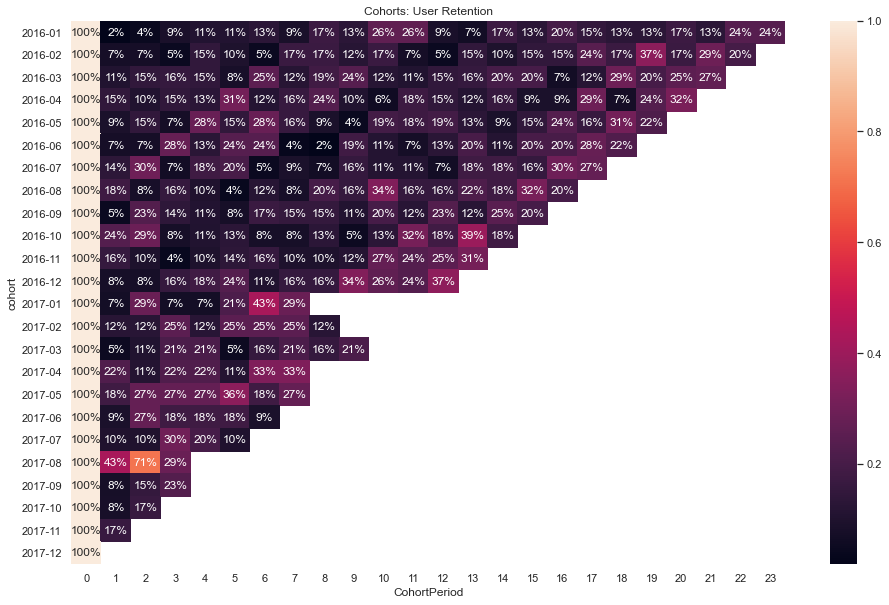

In [90]:
sns.set(style='white')
plt.figure(figsize=(16, 10))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

На первый взгляд кажется, что ретеншн не снизился, а скорее увеличился -
больше пользователей совершают повторные покупки. Посмотрим далее по сегментам

### Когортный анализ по сегментам

In [81]:
df_merged_Consumer = df_merged[df_merged['segment'] == 'Consumer']

In [85]:
cohorts_group = df_merged_Consumer.groupby(['cohort', 'invoice_month']).agg({'customer_id': pd.Series.nunique})
cohorts_group.rename(columns={'customer_id': 'TotalUsers',
                        'order_id': 'TotalOrders'}, inplace=True)
cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
cohorts_group.reset_index(inplace=True)
cohorts_group.set_index(['cohort', 'CohortPeriod'], inplace=True) 
cohort_group_size = cohorts_group['TotalUsers'].groupby(level=0).first()
user_retention_cust = cohorts_group['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)

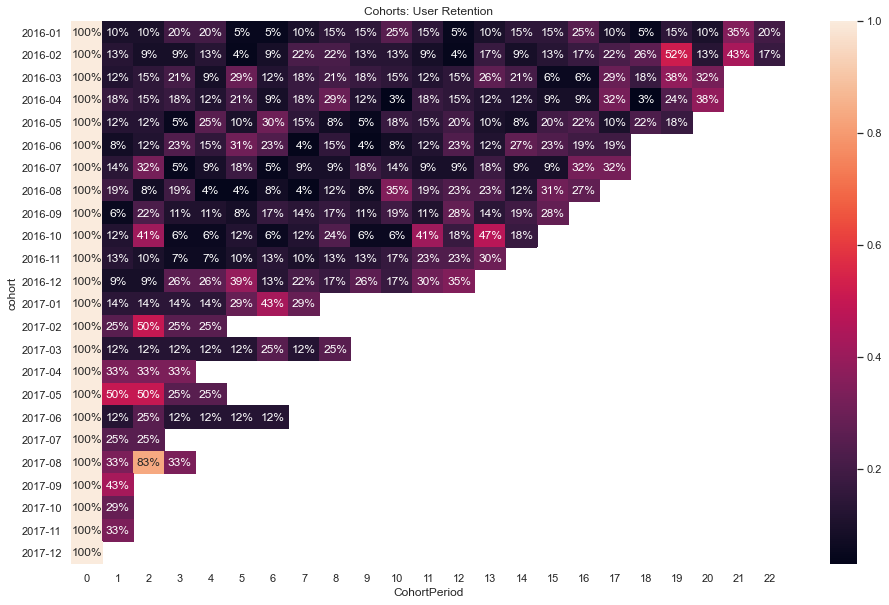

In [98]:
sns.set(style='white')
plt.figure(figsize=(16, 10))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention_cust.T, mask=user_retention_cust.T.isnull(), annot=True, fmt='.0%');

В сегменте Consumer ретеншн не снизился

In [94]:
df_merged_Corporate = df_merged[df_merged['segment'] == 'Corporate']

In [96]:
cohorts_group = df_merged_Corporate.groupby(['cohort', 'invoice_month']).agg({'customer_id': pd.Series.nunique})
cohorts_group.rename(columns={'customer_id': 'TotalUsers',
                        'order_id': 'TotalOrders'}, inplace=True)
cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
cohorts_group.reset_index(inplace=True)
cohorts_group.set_index(['cohort', 'CohortPeriod'], inplace=True) 
cohort_group_size = cohorts_group['TotalUsers'].groupby(level=0).first()
user_retention_corp = cohorts_group['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)

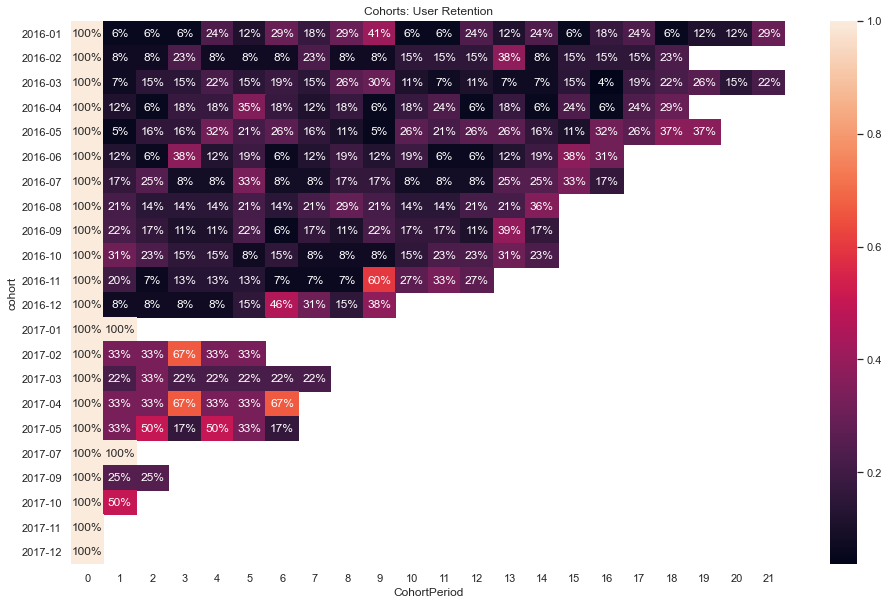

In [99]:
sns.set(style='white')
plt.figure(figsize=(16, 10))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention_corp.T, mask=user_retention_corp.T.isnull(), annot=True, fmt='.0%');

В сегменте Corporate ретеншн не снизился

In [100]:
df_merged_Office = df_merged[df_merged['segment'] == 'Home Office']

In [101]:
cohorts_group = df_merged_Office.groupby(['cohort', 'invoice_month']).agg({'customer_id': pd.Series.nunique})
cohorts_group.rename(columns={'customer_id': 'TotalUsers',
                        'order_id': 'TotalOrders'}, inplace=True)
cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
cohorts_group.reset_index(inplace=True)
cohorts_group.set_index(['cohort', 'CohortPeriod'], inplace=True) 
cohort_group_size = cohorts_group['TotalUsers'].groupby(level=0).first()
user_retention_off = cohorts_group['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)

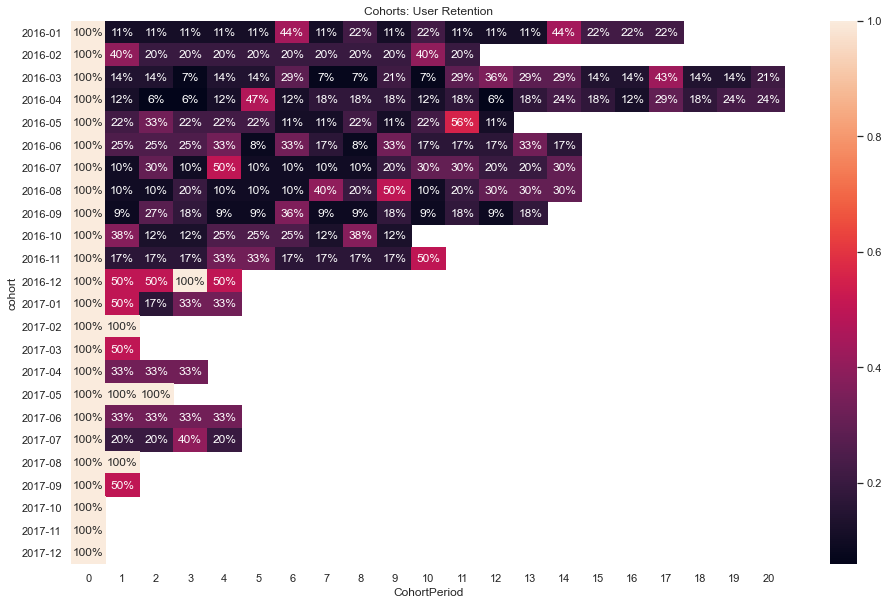

In [102]:
sns.set(style='white')
plt.figure(figsize=(16, 10))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention_off.T, mask=user_retention_off.T.isnull(), annot=True, fmt='.0%');

В сегменте Home Office ретеншн не снизился

## Посмотрим суммы первых и повторных заказов

In [104]:
def first_order(invoice_month, cohort):
    if invoice_month <= cohort:
        return 1
    return 0
def second_order(invoice_month, cohort):
    if invoice_month > cohort:
        return 1
    return 0

In [108]:
df_merged['first_order'] = df_merged.apply(lambda x: first_order(x['invoice_month'], x['cohort']), axis=1) \
* df_merged['sales']

In [110]:
df_merged['second_order'] = df_merged.apply(lambda x: second_order(x['invoice_month'], x['cohort']), axis=1) \
* df_merged['sales']

In [128]:
df_merged[(df_merged['first_order'] > 0) & (df_merged['year'] == 2017)].

,order_id,order_date,ship_mode,customer_id,sales,name,segment,state,city,year,month,week,invoice_month,cohort,first_order,second_order
1096,100055,2017-05-28,Standard,MD-17860,152.590,Michael Dominguez,Corporate,Indiana,Indianapolis,2017,5,21,2017-05,2017-05,152.590,0.0
1111,100524,2017-03-31,Second,CM-12115,782.400,Chad McGuire,Consumer,New York,New York City,2017,3,13,2017-03,2017-03,782.400,0.0
1128,101182,2017-09-04,First,KB-16405,56.136,Katrina Bavinger,Home Office,California,Apple Valley,2017,9,36,2017-09,2017-09,56.136,0.0
1149,102197,2017-12-20,Standard,DK-13150,364.272,David Kendrick,Corporate,Illinois,Decatur,2017,12,51,2017-12,2017-12,364.272,0.0
1168,102925,2017-11-05,Second,CD-12280,796.036,Christina DeMoss,Consumer,Washington,Seattle,2017,11,44,2017-11,2017-11,796.036,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2972,162670,2017-12-23,Second,MF-18250,1152.870,Monica Federle,Corporate,California,Los Angeles,2017,12,51,2017-12,2017-12,1152.870,0.0
2973,163195,2017-02-17,Second,LL-16840,29.160,Lauren Leatherbury,Consumer,New York,Rochester,2017,2,7,2017-02,2017-02,29.160,0.0
2985,166233,2017-07-03,Standard,MO-17950,24.000,Michael Oakman,Consumer,Texas,Dallas,2017,7,27,2017-07,2017-07,24.000,0.0
2994,168116,2017-11-04,Same Day,GT-14635,8167.420,Grant Thornton,Corporate,North Carolina,Burlington,2017,11,44,2017-11,2017-11,8167.420,0.0


In [119]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3002 entries, 0 to 3001
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       3002 non-null   int64         
 1   order_date     3002 non-null   datetime64[ns]
 2   ship_mode      3002 non-null   object        
 3   customer_id    3002 non-null   object        
 4   sales          3002 non-null   float64       
 5   name           3002 non-null   object        
 6   segment        3002 non-null   object        
 7   state          3002 non-null   object        
 8   city           3002 non-null   object        
 9   year           3002 non-null   int64         
 10  month          3002 non-null   int64         
 11  week           3002 non-null   int64         
 12  invoice_month  3002 non-null   object        
 13  cohort         3002 non-null   object        
 14  first_order    3002 non-null   float64       
 15  second_order   3002 n

In [129]:
df_merged[['year', 'segment', 'sales']].groupby(['year', 'segment']).sum()

sales
year segment                 
2016 Consumer     152722.9178
     Corporate    115745.6360
     Home Office   53765.7070
2017 Consumer      26233.6538
     Corporate     23371.7260
     Home Office   24103.2244

### Общие суммы заказов по сегментам выросли в 2017 году в сравнении с 2016

In [140]:
df_merged[['year', 'segment', 'sales']].groupby(['year', 'segment']).mean()

sales
year segment                
2016 Consumer     456.012134
     Corporate    490.773369
     Home Office  434.856764
2017 Consumer     378.886644
     Corporate    490.563538
     Home Office  501.455129

### Средний заказ по сегментам тоже вырос у Consumer и Home Office и остался неизменным у Corporate

In [138]:
df_merged[['year', 'segment', 'first_order']][(df_merged['first_order'] > 0)] \
.groupby(['year', 'segment']).mean()

first_order
year segment                 
2016 Consumer      436.351194
     Corporate     543.406742
     Home Office   433.594411
2017 Consumer      349.782051
     Corporate     631.668270
     Home Office   753.225763

### Средний первый заказ по сегментам вырос

In [139]:
df_merged[['year', 'segment', 'second_order']][(df_merged['second_order'] > 0)] \
.groupby(['year', 'segment']).mean()

second_order
year segment                  
2016 Consumer       478.873692
     Corporate      437.132659
     Home Office    436.183305
2017 Consumer       381.611793
     Corporate      479.114251
     Home Office    473.284988

### Видим, что средний повторный заказ снизился у самого большого сегмента - Consumer

# Посмотрим на доставку

In [145]:
df_merged[['year', 'segment', 'ship_mode', 'second_order']][(df_merged['second_order'] > 0) \
                                               & (df_merged['segment'] == 'Consumer')] \
                                               .groupby(['year', 'segment', 'ship_mode']).mean()

second_order
year segment  ship_mode              
2016 Consumer First        359.778558
              Same Day     416.840143
              Second       550.272221
              Standard     494.729068
2017 Consumer First        443.782863
              Same Day     276.809714
              Second       432.751205
              Standard     358.224714

Видим, что сумма повторного заказа по всем видам доставки кроме First упала для сегмента Consumer. 
нужно разбираться, что произошло - возможно, проблемы с доступностью товаров и доставкой их определенным способом

In [147]:
df_merged[['year', 'segment', 'ship_mode', 'second_order']][(df_merged['second_order'] > 0) \
                                               & (df_merged['segment'] != 'Consumer')] \
                                               .groupby(['year', 'segment', 'ship_mode']).mean()

second_order
year segment     ship_mode              
2016 Corporate   First        362.224703
                 Same Day     553.799400
                 Second       553.119167
                 Standard     409.911773
     Home Office First        525.048875
                 Same Day     415.485750
                 Second       438.825857
                 Standard     405.065046
2017 Corporate   First        444.819275
                 Same Day     613.666947
                 Second       558.300938
                 Standard     450.704959
     Home Office First        638.806500
                 Same Day     518.443875
                 Second       487.900021
                 Standard     417.299298

В других сегм
ентах такой проблемы нет